In [1]:
import numpy as np
import pandas as pd
import re
import json
import itertools
import matplotlib.pyplot as plt
import warnings
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
spotify_df = pd.read_csv('data/spotify_data.csv')

In [4]:
spotify_df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [5]:
spotify_df.dtypes

Unnamed: 0            int64
artist_name          object
track_name           object
track_id             object
popularity            int64
year                  int64
genre                object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
time_signature        int64
dtype: object

In [6]:
# Check if this is a list or a string that looks like a list
spotify_df['genre'].values

array(['acoustic', 'acoustic', 'acoustic', ..., 'trip-hop', 'trip-hop',
       'trip-hop'], dtype=object)

Feature Engineering

In [7]:
spotify_df.tail()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
1159759,1473391,Nicola Conte,Black Spirits,0m27F0IGHLGAWhqd6ccYst,4,2011,trip-hop,0.373,0.742,10,-6.453,0,0.0736,0.325,0.000141,0.1590,0.5220,107.951,344013,3
1159760,1473392,Nicola Conte,Quiet Dawn,6er9p611eHEcUCU50j7D57,3,2011,trip-hop,0.516,0.675,7,-7.588,0,0.0326,0.788,0.000129,0.1300,0.2640,119.897,285067,4
1159761,1473393,Amon Tobin,Morning Ms Candis,7jsMMqxy1tt0rH5FzYcZTQ,2,2011,trip-hop,0.491,0.440,5,-8.512,1,0.0274,0.477,0.003130,0.0936,0.0351,100.076,214253,4
1159762,1473394,Peace Orchestra,Happy Christmas (War Is Over),77lA1InUaXztuRk2vOzD1S,0,2011,trip-hop,0.480,0.405,0,-13.343,1,0.0276,0.431,0.000063,0.1250,0.2020,133.885,239133,3
1159763,1473395,Mo' Horizons,Hit the Road Jack (Pé Na Éstrada),4oMiOwhDZEdBuzAfhzRHbi,3,2011,trip-hop,0.782,0.861,1,-7.292,0,0.1250,0.220,0.000008,0.0581,0.8570,89.987,212227,4


In [8]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index
print(float_cols)

Index(['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo'],
      dtype='object')


In [9]:
ohe_cols = 'popularity'

In [10]:
# Change display options to avoid scientific notation
pd.options.display.float_format = '{:.2f}'.format

# describe(): This method is used to generate descriptive statistics that summarize the central tendency, dispersion, 
# and shape of a dataset’s distribution, excluding NaN values. 
spotify_df['popularity'].describe()

count   1159764.00
mean         18.38
std          15.89
min           0.00
25%           5.00
50%          15.00
75%          29.00
max         100.00
Name: popularity, dtype: float64

In [11]:
# creates a new column popularity_transform by scaling down the values of the popularity column and converting them to integers. 
# Each original popularity score is divided by 5, and the result is truncated to an integer. 
spotify_df['popularity_transform'] = spotify_df['popularity'].apply(lambda x: int(x / 5))

# Get the position of the 'popularity' column
popularity_index = spotify_df.columns.get_loc('popularity')

# Insert the 'popularity_transform' column next to the 'popularity' column
spotify_df.insert(popularity_index + 1, 'popularity_transform', spotify_df.pop('popularity_transform'))

In [12]:
spotify_df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,popularity_transform,year,genre,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,13,2012,acoustic,0.48,0.30,...,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,10,2012,acoustic,0.57,0.45,...,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,11,2012,acoustic,0.41,0.23,...,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,11,2012,acoustic,0.39,0.25,...,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,10,2012,acoustic,0.43,0.79,...,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86,244320,4


In [13]:
# Since tfidf cannot handle nulls, check if there are any null values in the entire DataFrame
any_null = spotify_df.isnull().values.any()
print(f"Any null values in DataFrame: {any_null}")

# Count of null values in each column
null_counts = spotify_df.isnull().sum()
print("\nCount of null values in each column:")
print(null_counts)

Any null values in DataFrame: True

Count of null values in each column:
Unnamed: 0               0
artist_name             15
track_name               1
track_id                 0
popularity               0
popularity_transform     0
year                     0
genre                    0
danceability             0
energy                   0
key                      0
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness         0
liveness                 0
valence                  0
tempo                    0
duration_ms              0
time_signature           0
dtype: int64


In [14]:
spotify_df['artist_name'] = spotify_df['artist_name'].apply(lambda d: d if isinstance(d, str) else '')
spotify_df['track_name'] = spotify_df['track_name'].apply(lambda d: d if isinstance(d, str) else '')


In [15]:
# Check if we eliminated the null values
any_null = spotify_df.isnull().values.any()
print(f"Any null values in DataFrame: {any_null}")

# Count of null values in each column
null_counts = spotify_df.isnull().sum()
print("\nCount of null values in each column:")
print(null_counts)

Any null values in DataFrame: False

Count of null values in each column:
Unnamed: 0              0
artist_name             0
track_name              0
track_id                0
popularity              0
popularity_transform    0
year                    0
genre                   0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
duration_ms             0
time_signature          0
dtype: int64


In [16]:
def create_one_hot_encoded_features(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    transformed_df = pd.get_dummies(df[column])
    feature_names = transformed_df.columns
    transformed_df.columns = [new_name + "|" + str(i) for i in feature_names]
    transformed_df.reset_index(drop = True, inplace = True)    
    return transformed_df

TF-IDF Section

Term Frequency Inverse Document Frequency. This is very common algorithm to transform text into a meaningful representation of numbers which is used to fit machine algorithm for prediction. It is a statistical formula to convert text documents into vectors based on the relevancy of the word. It is based on the bag of the words model to create a matrix containing the information about less relevant and most relevant words in the document.

In [17]:
# Build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    # Ensure 'genre' column is properly formatted
    df['genre'] = df['genre'].apply(lambda x: str(x) if isinstance(x, str) else '')
    
    # tfidf genre lists
    tfidf = TfidfVectorizer()
    processed_genres = df['genre']

    # Check if the processed genres are not empty
    if processed_genres.str.strip().eq('').any():
        raise ValueError("Some documents are empty after preprocessing. Check the 'genre' column.")

    tfidf_matrix = tfidf.fit_transform(processed_genres)
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names_out()]
    genre_df.reset_index(drop=True, inplace=True)

    year_ohe = create_one_hot_encoded_features(df, 'year','year') * 0.5
    popularity_ohe = create_one_hot_encoded_features(df, 'popularity_transform','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['track_id'] = df['track_id'].values
    
    return final

In [18]:
complete_feature_set = create_feature_set(spotify_df, float_cols = float_cols)

In [19]:
complete_feature_set.head()

,genre|acoustic,genre|afrobeat,genre|age,genre|alt,genre|ambient,genre|and,genre|bass,genre|black,genre|blues,genre|breakbeat,...,year|2015,year|2016,year|2017,year|2018,year|2019,year|2020,year|2021,year|2022,year|2023,track_id
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,53QF56cjZA9RTuuMZDrSA6
1,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1s8tP3jP4GZcyHDsjvw218
2,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7BRCa8MPiyuvr2VU3O9W0F
3,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,63wsZUhUZLlh1OsyrZq7sz
4,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6nXIYClvJAfi6ujLiKqEq8


Spotify API

In [20]:
import os
import sys
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyOAuth
from spotipy.oauth2 import SpotifyClientCredentials

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv()  

spotify_client_id = os.getenv('CLIENT_ID')
spotify_client_secret = os.getenv('CLIENT_SECRET')

In [21]:
# The set of scopes you set during the authorization, determines the access permissions that the user is asked to grant.
# scope = "playlist-read-private playlist-modify-private playlist-modify-public user-read-playback-position user-top-read user-read-recently-played user-library-read"
scope = "user-library-read"

In [22]:
if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [ ]:
# TODO: Implement Authorization Code with PKCE. Found this in documentation:  class spotipy.oauth2.SpotifyPKCE(client_id=None, redirect_uri=None, state=None, scope=None, cache_path=None, username=None, proxies=None, requests_timeout=None, requests_session=True, open_browser=True, cache_handler=None)
# Authorization Code with PKCE since I will not be using a server. I will have to implement Authorization Code with PKCE if I want
# to expose this in a web app.
 
# This section initializes the Spotify client using the Client Credentials Flow, which is used for accessing public Spotify data that does not require user authorization.
# Since this flow does not include authorization, only endpoints that do not access user information can be accessed.
# auth_manager = SpotifyClientCredentials(client_id=spotify_client_id, client_secret=spotify_client_secret)
# sp = spotipy.Spotify(auth_manager=auth_manager)

auth_manager = SpotifyOAuth(spotify_client_id, spotify_client_secret, 'https://localhost:8888/callback', scope=scope)
# Generate the authorization URL
auth_url = auth_manager.get_authorize_url()

# Open the authorization URL in the default browser
print(f'Please navigate to the following URL to authorize the application: {auth_url}')
import webbrowser
webbrowser.open(auth_url)

In [24]:
# Manually enter the full redirected URL after authorization
redirected_url = input("")

# Extract the authorization code from the URL
code = auth_manager.parse_response_code(redirected_url)

# Obtain the access token using the authorization code
token_info = auth_manager.get_access_token(code)

# Initialize Spotify client with the access token
sp = spotipy.Spotify(auth=token_info['access_token'])

# token = util.prompt_for_user_token(scope, client_id=spotify_client_id, client_secret=spotify_client_secret, redirect_uri='https://localhost:8888/callback')

In [25]:
# The authorization code flow is suitable for long-running applications (e.g. web and mobile apps) where the user grants permission only once.
# If you’re using the authorization code flow in a mobile app, or any other type of application where the client secret can't be safely stored, then you should use the PKCE extension.
# This flow is required for accessing user-specific data, such as the user's library, playlists, and other private data that the user has given permission to access.

# sp = spotipy.Spotify(auth=token)

# Note: Both types of authentication are not needed on an actual app.

In [26]:
# Gather playlists names and images

id_name = {}
list_photo = {}

for i in sp.current_user_playlists()['items']:
    # id_name[i['name']] = i['id']
    # list_photo[i['name']] = i['images'][0]['url']

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

print('this is id_name')
id_name


this is id_name


{'Binaural': '2EQzovlAPMf5ngJY9FWnQL',
 'Intro': '6FCZL1iXY013cBr8AiZcdx',
 'Graduación ': '3WOXeNLTBTP88iE4gRRoJy',
 'Atmosphere': '04uaMh2FpFRQ6EmVyA5bKt',
 'Urbano': '3shAxbFwXTIyV11HYOrzOi',
 'Latino': '1sTzLrEQTkvU1fPW7rwTDG',
 'Chill': '5M0XfG1V7p5BTXR2jRjQAn',
 'Rock': '0MQWIgtR2xVYx2L2FB0Hla',
 'Rock en español': '2EEnqFoLhXZX4fq1py2xBQ'}

In [27]:
def create_necessary_outputs(playlist_name, id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for index, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):

        # row, column
        playlist.loc[index, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[index, 'name'] = i['track']['name']
        playlist.loc[index, 'id'] = i['track']['id'] 
        playlist.loc[index, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[index, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  

    playlist = playlist[playlist['id'].isin(df['track_id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [28]:
id_name

{'Binaural': '2EQzovlAPMf5ngJY9FWnQL',
 'Intro': '6FCZL1iXY013cBr8AiZcdx',
 'Graduación ': '3WOXeNLTBTP88iE4gRRoJy',
 'Atmosphere': '04uaMh2FpFRQ6EmVyA5bKt',
 'Urbano': '3shAxbFwXTIyV11HYOrzOi',
 'Latino': '1sTzLrEQTkvU1fPW7rwTDG',
 'Chill': '5M0XfG1V7p5BTXR2jRjQAn',
 'Rock': '0MQWIgtR2xVYx2L2FB0Hla',
 'Rock en español': '2EEnqFoLhXZX4fq1py2xBQ'}

In [30]:
spotify_df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,popularity_transform,year,genre,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,13,2012,acoustic,0.48,0.30,...,-10.06,1,0.04,0.69,0.00,0.12,0.14,133.41,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,10,2012,acoustic,0.57,0.45,...,-10.29,1,0.03,0.48,0.00,0.10,0.52,140.18,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,11,2012,acoustic,0.41,0.23,...,-13.71,1,0.03,0.34,0.00,0.09,0.14,139.83,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,11,2012,acoustic,0.39,0.25,...,-9.85,1,0.04,0.81,0.00,0.08,0.51,204.96,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,10,2012,acoustic,0.43,0.79,...,-5.42,0,0.03,0.07,0.02,0.11,0.22,171.86,244320,4


In [31]:
playlist_rock = create_necessary_outputs('Rock', id_name, spotify_df)

In [32]:
playlist_rock

,artist,name,id,url,date_added
92,Red Hot Chili Peppers,Sick Love,6GsP3uMCd0Dn5T37C93waZ,https://i.scdn.co/image/ab67616d00001e0258406b...,2024-05-12 06:15:17+00:00
83,Porcupine Tree,Open Car,0S7Eb7sl3eqRPR9kVUxCQl,https://i.scdn.co/image/ab67616d00001e02c6d4bd...,2024-03-09 00:05:05+00:00
81,Queens of the Stone Age,Song For The Dead,66UbHESsyfaXdoxlqVBa1T,https://i.scdn.co/image/ab67616d00001e029b62c3...,2024-03-01 16:30:33+00:00
80,Queens of the Stone Age,First It Giveth,5yprGKAwV1GSJSiATa50Ni,https://i.scdn.co/image/ab67616d00001e029b62c3...,2024-03-01 16:18:22+00:00
78,Queens of the Stone Age,I Appear Missing,0Dv8OfSPwrXmNNbE70b9Dq,https://i.scdn.co/image/ab67616d00001e02a705b5...,2024-02-29 00:57:14+00:00
77,Linkin Park,Somewhere I Belong,3agtg0x11wPvLIWkYR39nZ,https://i.scdn.co/image/ab67616d00001e025f1f51...,2024-02-15 14:27:33+00:00
74,Greta Van Fleet,Heat Above,0zlaa4AmbFE7MVDijsyD9Q,https://i.scdn.co/image/ab67616d00001e02339cc0...,2024-01-26 20:09:48+00:00
72,Greta Van Fleet,You're The One,0iYBNrznkCwhN3xCmNVJpo,https://i.scdn.co/image/ab67616d00001e027b9e5a...,2024-01-25 00:50:48+00:00
71,Greta Van Fleet,Stardust Chords,07p7PALHp6ZcD5tmlbO94N,https://i.scdn.co/image/ab67616d00001e02339cc0...,2024-01-22 18:26:18+00:00
70,The Black Keys,Little Black Submarines,1PXsUXSM3LF2XNSkmIldPb,https://i.scdn.co/image/ab67616d00001e026a21b9...,2024-01-22 16:25:30+00:00


In [45]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for index, url in enumerate(temp):
        plt.subplot(int(len(temp) / columns + 1), columns, index + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[index], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

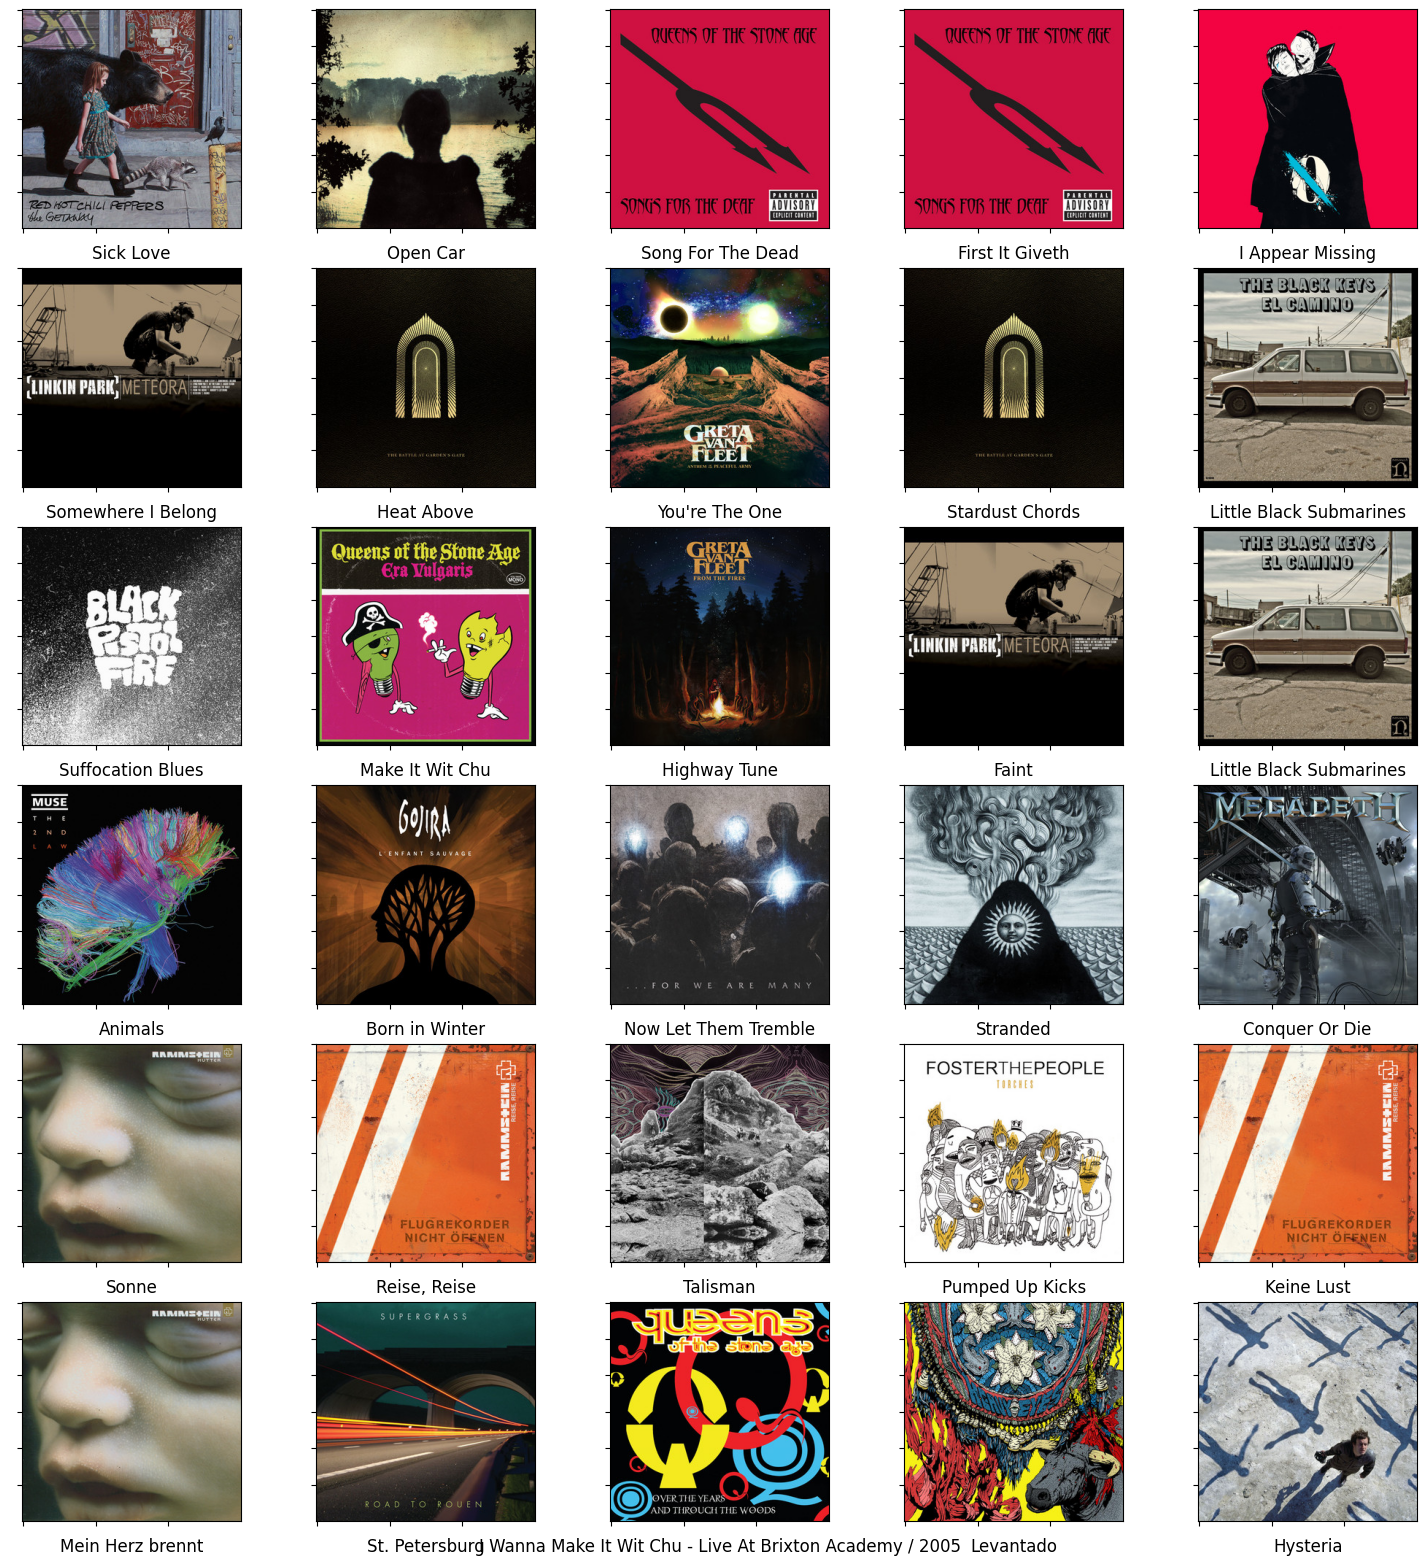

In [46]:
visualize_songs(playlist_rock)

In [ ]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['track_id'].isin(playlist_df['id'].values)]
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    # The purpose of this line is to create a new DataFrame complete_feature_set_nonplaylist that contains all tracks from complete_feature_set 
    # that are not in the user's playlist (i.e., their track_id is not in playlist_df['id']).
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['track_id'].isin(playlist_df['id'].values)]
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    # the date of the most recently added song. 
    most_recent_date = playlist_feature_set.iloc[0, -1]
    
    for index, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[index, 'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    # Exponential decay function for setting the weights    
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [ ]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_EDM, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_c